In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/data/slidetags/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3544
    obs: 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'cell_type_int'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'spatial'
    layers: 'normalized_count'

In [4]:
import sys
sys.path.append('/Users/koush/Projects/SpaceOracle/src/')

In [5]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
# sc.tl.umap(adata)
# sc.tl.leiden(adata, resolution=0.5)

CPU times: user 2min 13s, sys: 3min 36s, total: 5min 50s
Wall time: 38.8 s


In [7]:
%%time

sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')

CPU times: user 2.33 s, sys: 1.49 s, total: 3.82 s
Wall time: 378 ms


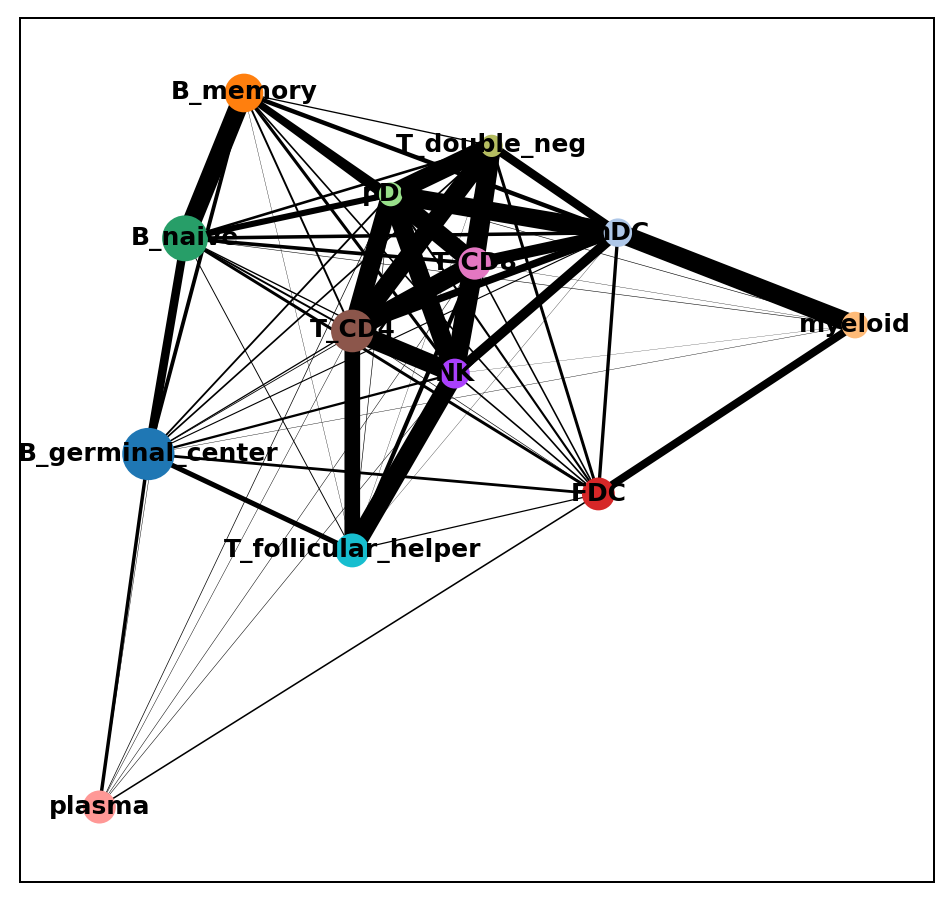

CPU times: user 607 ms, sys: 519 ms, total: 1.13 s
Wall time: 150 ms


In [8]:
%%time

sc.tl.paga(adata, groups='cell_type')
plt.rcParams["figure.figsize"] = [6, 6]
sc.pl.paga(adata)

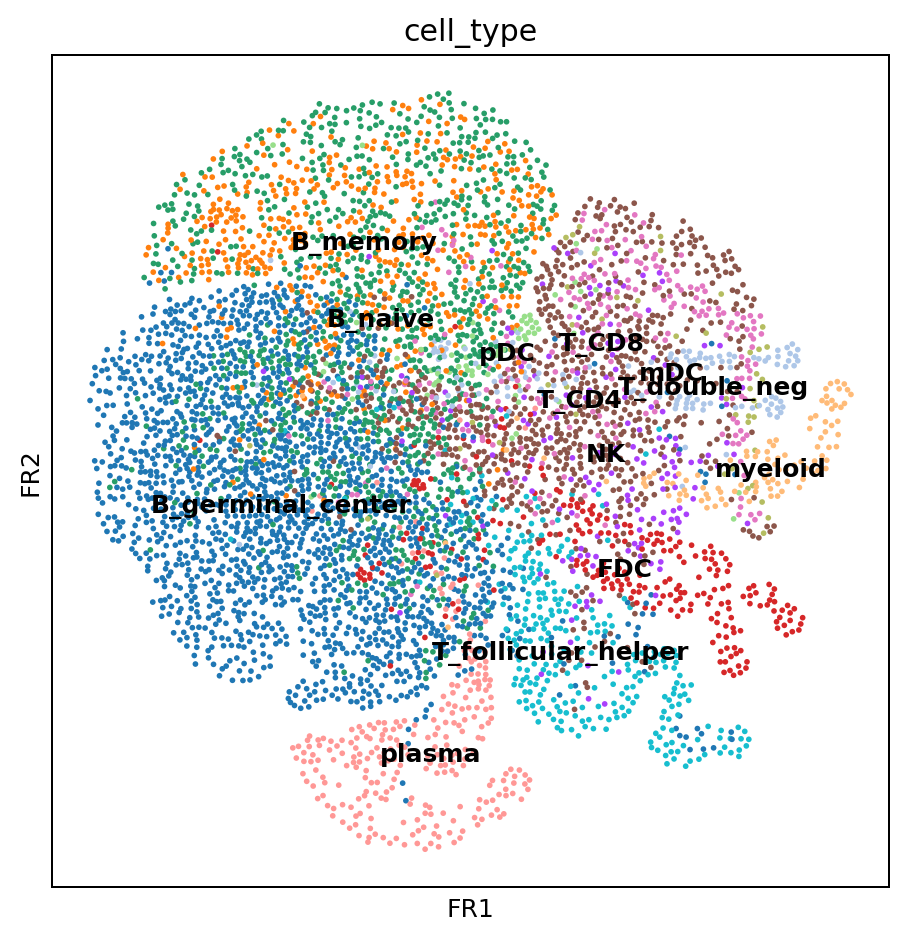

In [9]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)
sc.pl.draw_graph(adata, color='cell_type', legend_loc='on data')

In [10]:
adata.layers["raw_count"] = np.exp(adata.X) - 1

In [11]:
oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_draw_graph_fr"
)

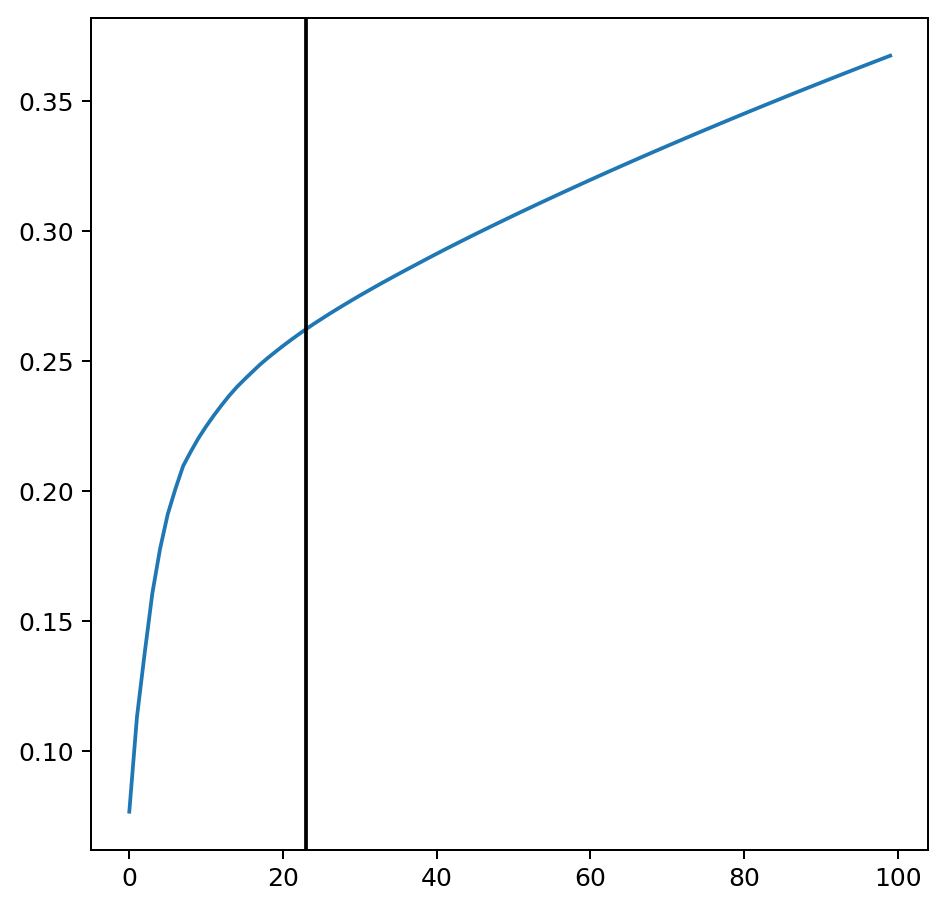

23


In [12]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()

print(n_comps)
n_comps = min(n_comps, 50)

In [13]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :5778
Auto-selected k is :144


In [14]:
oracle.knn_imputation(
    n_pca_dims=n_comps, 
    k=k, 
    balanced=True, 
    b_sight=k*8,
    b_maxl=k*4, 
    n_jobs=4
)

In [15]:
base_GRN = co.data.load_human_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


In [16]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=10,
    verbose_level=10
)

  0%|          | 0/13 [00:00<?, ?it/s]

Inferring GRN for B_germinal_center...


  0%|          | 0/3418 [00:00<?, ?it/s]

  8%|▊         | 1/13 [01:23<16:42, 83.55s/it]

Inferring GRN for B_memory...


  0%|          | 0/3418 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [02:39<14:29, 79.08s/it]

Inferring GRN for B_naive...


  0%|          | 0/3418 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [03:56<13:02, 78.24s/it]

Inferring GRN for FDC...


  0%|          | 0/3418 [00:00<?, ?it/s]

 31%|███       | 4/13 [05:12<11:34, 77.21s/it]

Inferring GRN for NK...


  0%|          | 0/3418 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [06:27<10:11, 76.48s/it]

Inferring GRN for T_CD4...


  0%|          | 0/3418 [00:00<?, ?it/s]

 46%|████▌     | 6/13 [07:42<08:52, 76.06s/it]

Inferring GRN for T_CD8...


  0%|          | 0/3418 [00:00<?, ?it/s]

 54%|█████▍    | 7/13 [08:57<07:34, 75.76s/it]

Inferring GRN for T_double_neg...


  0%|          | 0/3418 [00:00<?, ?it/s]

 62%|██████▏   | 8/13 [10:13<06:18, 75.79s/it]

Inferring GRN for T_follicular_helper...


  0%|          | 0/3418 [00:00<?, ?it/s]

 69%|██████▉   | 9/13 [11:30<05:04, 76.17s/it]

Inferring GRN for mDC...


  0%|          | 0/3418 [00:00<?, ?it/s]

 77%|███████▋  | 10/13 [12:46<03:47, 75.94s/it]

Inferring GRN for myeloid...


  0%|          | 0/3418 [00:00<?, ?it/s]

 85%|████████▍ | 11/13 [14:01<02:31, 75.72s/it]

Inferring GRN for pDC...


  0%|          | 0/3418 [00:00<?, ?it/s]

 92%|█████████▏| 12/13 [15:17<01:15, 75.71s/it]

Inferring GRN for plasma...


  0%|          | 0/3418 [00:00<?, ?it/s]

100%|██████████| 13/13 [16:33<00:00, 76.40s/it]

CPU times: user 11min 7s, sys: 29.4 s, total: 11min 37s
Wall time: 16min 33s


In [17]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=10, 
    use_cluster_specific_TFdict=True
)

  0%|          | 0/13 [00:00<?, ?it/s]

In [18]:
import pickle

with open('/Users/koush/Projects/SpaceOracle/data/slidetags/tonsil_colinks.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

# with open('/Users/koush/Projects/SpaceOracle/data/slidetags/tonsil_celloracle.pkl', 'wb') as f:
#     pickle.dump(oracle, f)

In [19]:
adata

AnnData object with n_obs × n_vars = 5778 × 3544
    obs: 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'cell_type_int'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'diffmap_evals', 'paga', 'cell_type_sizes', 'cell_type_colors', 'draw_graph'
    obsm: 'spatial', 'X_pca', 'X_diffmap', 'X_draw_graph_fr'
    varm: 'PCs'
    layers: 'normalized_count', 'raw_count'
    obsp: 'distances', 'connectivities'

In [20]:
{i: k for i, (k,) in enumerate(zip(list(links.links_dict.keys())))}

{0: 'B_germinal_center',
 1: 'B_memory',
 2: 'B_naive',
 3: 'FDC',
 4: 'NK',
 5: 'T_CD4',
 6: 'T_CD8',
 7: 'T_double_neg',
 8: 'T_follicular_helper',
 9: 'mDC',
 10: 'myeloid',
 11: 'pDC',
 12: 'plasma'}